In [2]:
import io
import bson                       # this is installed with the pymongo package
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.io import imread
# from skimage.data import imread   # or, whatever image library you prefer
import multiprocessing as mp 
import numpy as np
import pandas as pd

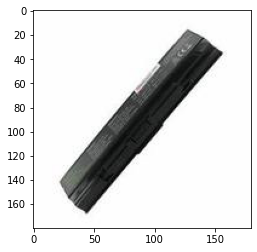

In [3]:
# Simple data processing

data = bson.decode_file_iter(open('/content/drive/MyDrive/Colab Notebooks/dataset/train_example.bson', 'rb'))

prod_to_category = dict()
prod_to_img = dict()

prod_id = []
cat_id = []
img_arr = []
z2=[]
f=0
for c, d in enumerate(data):
    product_id = d['_id']
    category_id = d['category_id'] # This won't be in Test data 
    prod_to_category[product_id] = category_id
    for e, pic in enumerate(d['imgs']):
        picture = imread(io.BytesIO(pic['picture']))
        z2.append(picture)
        pic.update(ImageName=f)
        f+=1
        prod_id.append(product_id)
        cat_id.append(category_id)
        img_arr.append(picture)
        
df = pd.DataFrame(list(zip(img_arr, prod_id, cat_id)), columns=['img_arr', 'prod_id', 'cat_id'])

prod_to_category = pd.DataFrame.from_dict(prod_to_category, orient='index')
prod_to_category.index.name = '_id'
prod_to_category.rename(columns={0: 'category_id'}, inplace=True)
prod_to_category.head()
plt.imshow(picture);

prod_to_img = pd.DataFrame.from_dict(prod_to_img, orient='index')
prod_to_img.index.name = '_id'
prod_to_img.rename(columns={0: 'img'}, inplace=True)
plt.imshow(picture);
#extract and save images to specific file path
for i in range(0,len(z2)):
    plt.imsave('/content/drive/MyDrive/Colab Notebooks/dataset/output/'+str(i)+'.jpg',z2[i])


In [3]:
#np.unique(df['prod_id'])

In [20]:
df.head()

,img_arr,prod_id,cat_id
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,1000010653
1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1,1000010653
2,"[[[254, 254, 254], [254, 254, 254], [254, 254,...",2,1000004079
3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",3,1000004141
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",4,1000015539


**Image similarity by artistic style**





In [4]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
print(tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import glob
import ntpath
import cv2

from sklearn.metrics.pairwise import cosine_similarity
import scipy as sc

2.4.1


Founnd [110] images


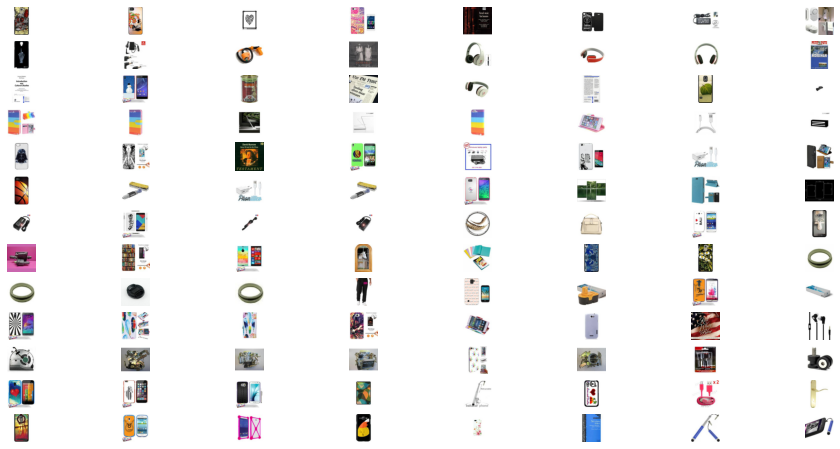

In [5]:
image_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/dataset/output/*.jpg')
print(f'Founnd [{len(image_paths)}] images')

images = {}
for image_path in image_paths:
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])         # switch it to r, g, b
    image = cv2.resize(image, (200, 200))
    images[ntpath.basename(image_path)] = image      

n_col = 8
n_row = int(len(images)/n_col)
f, ax = plt.subplots(n_row, n_col, figsize=(16, 8))
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].imshow(list(images.values())[n_col*i + j])
        ax[i, j].set_axis_off()

In [6]:
def load_image(image):
  image = plt.imread(image)
  img = tf.image.convert_image_dtype(image, tf.float32)
  img = tf.image.resize(img, [400, 400])
  img = img[tf.newaxis, :] # shape -> (batch_size, h, w, d)
  return img

# content layers describe the image subject
content_layers = ['block5_conv2'] 

# style layers describe the image style
# we exclude the upper level layes to focus on small-size style details
style_layers = [ 
        'block1_conv1',
        'block2_conv1',
        'block3_conv1', 
        #'block4_conv1', 
        #'block5_conv1'
    ] 

def selected_layers_model(layer_names, baseline_model):
  outputs = [baseline_model.get_layer(name).output for name in layer_names]
  model = Model([vgg.input], outputs)
  return model

# style embedding is computed as concatenation of gram matrices of the style layers
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

class StyleModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleModel, self).__init__()
    self.vgg =  selected_layers_model(style_layers + content_layers, vgg)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    # scale back the pixel values
    inputs = inputs*255.0
    # preprocess them with respect to VGG19 stats
    preprocessed_input = preprocess_input(inputs)
    # pass through the reduced network
    outputs = self.vgg(preprocessed_input)
    # segregate the style and content representations
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # calculate the gram matrix for each layer
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    # assign the content representation and gram matrix in
    # a layer by layer fashion in dicts
    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

def image_to_style(image_tensor):
    extractor = StyleModel(style_layers, content_layers)
    return extractor(image_tensor)['style']

def style_to_vec(style):
    # concatenate gram matrics in a flat vector
    return np.hstack([np.ravel(s) for s in style.values()]) 
    
# compute styles
image_style_embeddings = {}
for image_path in tqdm(image_paths): 
    image_tensor = load_image(image_path)
    style = style_to_vec( image_to_style(image_tensor) )
    image_style_embeddings[ntpath.basename(image_path)] = style

80142336/80134624 [==============================] - 1s 0us/step


100%|██████████| 110/110 [00:05<00:00, 20.28it/s]


In [7]:
def search_by_style(reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    return sorted_neighbors[:11]
   # f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    #for i, img in enumerate(sorted_neighbors[:max_results]):
     #   ax[i].imshow(images[img[0]])
      #  ax[i].set_axis_off()
    
   # plt.show()

# images mostly match the reference style, although not perfectly
#search_by_style('102.jpg')
#search_by_style('11.jpg')



In [8]:
a = [search_by_style(image_name) for image_name in images.keys()]

In [9]:
b = pd.DataFrame(a)
b

,0,1,2,3,4,5,6,7,8,9,10
0,"(1.jpg, 0.0)","(37.jpg, 0.03300333023071289)","(98.jpg, 0.03548711538314819)","(61.jpg, 0.03619694709777832)","(62.jpg, 0.03848212957382202)","(0.jpg, 0.03901493549346924)","(108.jpg, 0.04312163591384888)","(93.jpg, 0.04345250129699707)","(41.jpg, 0.04546177387237549)","(106.jpg, 0.04568743705749512)","(51.jpg, 0.04626864194869995)"
1,"(0.jpg, 0.0)","(37.jpg, 0.03423106670379639)","(93.jpg, 0.038538992404937744)","(1.jpg, 0.03901493549346924)","(41.jpg, 0.04167437553405762)","(51.jpg, 0.0467149019241333)","(16.jpg, 0.04774808883666992)","(98.jpg, 0.048406243324279785)","(68.jpg, 0.05229675769805908)","(86.jpg, 0.05392521619796753)","(57.jpg, 0.05535167455673218)"
2,"(3.jpg, 0.0)","(2.jpg, 0.04439574480056763)","(106.jpg, 0.04788029193878174)","(105.jpg, 0.05368572473526001)","(37.jpg, 0.063232421875)","(32.jpg, 0.06725126504898071)","(55.jpg, 0.07026618719100952)","(8.jpg, 0.07171773910522461)","(1.jpg, 0.07337909936904907)","(4.jpg, 0.07414007186889648)","(51.jpg, 0.07770061492919922)"
3,"(10.jpg, 0.0)","(45.jpg, 0.05377960205078125)","(76.jpg, 0.07021915912628174)","(58.jpg, 0.08114022016525269)","(94.jpg, 0.08920711278915405)","(34.jpg, 0.0918351411819458)","(73.jpg, 0.10529327392578125)","(17.jpg, 0.11062020063400269)","(99.jpg, 0.11225444078445435)","(68.jpg, 0.11436325311660767)","(85.jpg, 0.11468535661697388)"
4,"(9.jpg, 0.0)","(88.jpg, 0.10309600830078125)","(38.jpg, 0.12682729959487915)","(57.jpg, 0.14133739471435547)","(108.jpg, 0.1504148244857788)","(104.jpg, 0.15730804204940796)","(17.jpg, 0.15890640020370483)","(86.jpg, 0.15930336713790894)","(98.jpg, 0.1660008430480957)","(8.jpg, 0.1675160527229309)","(16.jpg, 0.16790986061096191)"
...,...,...,...,...,...,...,...,...,...,...,...
105,"(105.jpg, 0.0)","(106.jpg, 0.002229750156402588)","(104.jpg, 0.022382676601409912)","(55.jpg, 0.035136520862579346)","(8.jpg, 0.03858214616775513)","(4.jpg, 0.0386127233505249)","(22.jpg, 0.04431939125061035)","(37.jpg, 0.045083045959472656)","(1.jpg, 0.04643690586090088)","(108.jpg, 0.047023117542266846)","(93.jpg, 0.050155460834503174)"
106,"(106.jpg, 0.0)","(105.jpg, 0.002229750156402588)","(104.jpg, 0.027008056640625)","(55.jpg, 0.03347140550613403)","(4.jpg, 0.03638350963592529)","(8.jpg, 0.03817933797836304)","(37.jpg, 0.04197937250137329)","(22.jpg, 0.045168936252593994)","(1.jpg, 0.04568743705749512)","(2.jpg, 0.0458294153213501)","(3.jpg, 0.04788029193878174)"
107,"(107.jpg, 0.0)","(103.jpg, 0.056010663509368896)","(49.jpg, 0.06327861547470093)","(52.jpg, 0.06570976972579956)","(87.jpg, 0.06669926643371582)","(109.jpg, 0.07145535945892334)","(36.jpg, 0.07842445373535156)","(35.jpg, 0.07842445373535156)","(12.jpg, 0.08859074115753174)","(80.jpg, 0.08903747797012329)","(7.jpg, 0.09030455350875854)"
108,"(108.jpg, 0.0)","(104.jpg, 0.03548818826675415)","(72.jpg, 0.042105019092559814)","(1.jpg, 0.04312163591384888)","(105.jpg, 0.047023117542266846)","(106.jpg, 0.05360656976699829)","(61.jpg, 0.05408352613449097)","(93.jpg, 0.0552520751953125)","(37.jpg, 0.060988008975982666)","(98.jpg, 0.061566710472106934)","(8.jpg, 0.06539297103881836)"


In [27]:
#Returns the first element of any list/tuple
def test(sorted_neighbour_tuple):
    return sorted_neighbour_tuple[0]

In [28]:
c = b.applymap(test)

In [29]:
c.to_csv("Method1.csv")

FAISS

In [14]:
!apt install libomp-dev
!python -m pip install --upgrade faiss faiss-gpu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 31 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 1s (424 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 160983 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_amd64.deb ...
Unpacking libomp5:amd64 (5.0.1-1) ...
Selecting previously unselected package libomp-dev.
Preparing to unpack .../libomp-dev_5.0.1-1_amd64.deb ...
Unpacking libomp-dev (5.0.1-

In [15]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import tensorflow as tf
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import faiss
from matplotlib import pyplot as plt

In [16]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Defining 50 layer residual network : ResNet50 trained on million images, to get features for our dataset.
model = ResNet50(weights='imagenet', include_top=False,
                 input_shape=(224, 224, 3))

#Extracting features of images by including image path and model trained above
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

94773248/94765736 [==============================] - 1s 0us/step


In [18]:
#Trying to extract features for all type of image formats specified. We are getting numerical vectors for images.
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list
root_dir = '/content/drive/MyDrive/Colab Notebooks/dataset/output'
filenames = sorted(get_file_list(root_dir))

In [19]:
feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [20]:
len(feature_list)

110

In [21]:
feature_list=np.array(feature_list)
feature_list.shape
#Number of features = 100352 for 116 images


(110, 100352)

In [23]:
dimensions=feature_list.shape[1]
db_vectors=feature_list
nlist = 1  # number of clusters
quantiser = faiss.IndexFlatL2(dimensions) #to assign the vectors to a particular cluster. This is index that uses the L2 distance metric 
index = faiss.IndexIVFFlat(quantiser, dimensions, nlist,   faiss.METRIC_L2) #defining index

In [24]:
print(index.is_trained)   # False
index.train(db_vectors)  # train on the database vectors
print(index.ntotal)   # 0
index.add(db_vectors)   # add the vectors and update the index
print(index.is_trained)  # True
print(index.ntotal)

False
0
True
110


In [25]:
nprobe = 2  # find 2 most similar clusters
n_query = 1  
k = 10  # return 3 nearest neighbours
np.random.seed(0)   
#Trying out a random images at 23rd position in images folder :
distances, indices = index.search(feature_list[23].reshape(1,-1), k)

In [26]:
distances

array([[0.       , 0.9913699, 1.3422129, 1.4434987, 1.451539 , 1.4622688,
        1.5304719, 1.5309459, 1.537258 , 1.5473386]], dtype=float32)

In [27]:
indices #Similiar images indices

array([[23, 24, 18,  3, 22, 43, 31, 27, 57, 21]])

In [28]:
faiss.write_index(index,"vector.index")  # save the index to 
# diskindex = faiss.read_index("vector.index")  # load the index

In [29]:
diskindex = faiss.read_index("vector.index")

In [30]:
type(feature_list)

numpy.ndarray

In [31]:
feature_list.shape

(110, 100352)

In [33]:
nprobe = 1  # find 2 most similar clusters
n_query = 20  
k = 10  # return 3 nearest neighbours
np.random.seed(0)   
query_vectors = feature_list#np.random.random((n_query, dimension)).astype('float32')
distances, indices = index.search(query_vectors, k)

In [34]:
faiss.write_index(index,"vector.index")

In [35]:
diskindex = faiss.read_index("vector.index")

In [36]:
feature_list.shape

(110, 100352)

In [37]:
pickle.dump(feature_list, open('features-caltech101-resnet.pickle', 'wb'))
pickle.dump(filenames, open('filenames-caltech101.pickle','wb'))

In [38]:
filenames = pickle.load(open('filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('features-caltech101-resnet.pickle', 'rb'))
filenames[1]

'/content/drive/MyDrive/Colab Notebooks/dataset/output/1.jpg'

In [39]:
filename1 = [i.split('/')[7] for i in filenames]
filename1[1:10]

['1.jpg',
 '10.jpg',
 '100.jpg',
 '101.jpg',
 '102.jpg',
 '103.jpg',
 '104.jpg',
 '105.jpg',
 '106.jpg']

In [40]:
index = []
for i in range(len(filename1)):
  index.append(i)
index[1:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [41]:
df = pd.DataFrame()
# df['index'] = index
df['images'] = filename1
df.head(10)

,images
0,0.jpg
1,1.jpg
2,10.jpg
3,100.jpg
4,101.jpg
5,102.jpg
6,103.jpg
7,104.jpg
8,105.jpg
9,106.jpg


In [42]:
indices_df = pd.DataFrame(indices)
indices_df

,0,1,2,3,4,5,6,7,8,9
0,0,69,68,103,101,106,36,1,61,94
1,1,69,68,106,103,0,36,108,61,101
2,2,38,41,76,28,107,100,84,98,75
3,3,18,24,68,27,23,29,101,106,69
4,4,82,27,69,103,94,106,0,36,29
...,...,...,...,...,...,...,...,...,...,...
105,105,94,59,53,34,106,61,31,25,103
106,106,69,61,27,103,101,55,1,36,25
107,107,60,75,50,98,100,38,95,19,57
108,108,69,25,1,68,55,0,103,61,36


In [43]:
df1 = df.to_dict()
df1 = df1['images']
df1

{0: '0.jpg',
 1: '1.jpg',
 2: '10.jpg',
 3: '100.jpg',
 4: '101.jpg',
 5: '102.jpg',
 6: '103.jpg',
 7: '104.jpg',
 8: '105.jpg',
 9: '106.jpg',
 10: '107.jpg',
 11: '108.jpg',
 12: '109.jpg',
 13: '11.jpg',
 14: '12.jpg',
 15: '13.jpg',
 16: '14.jpg',
 17: '15.jpg',
 18: '16.jpg',
 19: '17.jpg',
 20: '18.jpg',
 21: '19.jpg',
 22: '2.jpg',
 23: '20.jpg',
 24: '21.jpg',
 25: '22.jpg',
 26: '23.jpg',
 27: '24.jpg',
 28: '25.jpg',
 29: '26.jpg',
 30: '27.jpg',
 31: '28.jpg',
 32: '29.jpg',
 33: '3.jpg',
 34: '30.jpg',
 35: '31.jpg',
 36: '32.jpg',
 37: '33.jpg',
 38: '34.jpg',
 39: '35.jpg',
 40: '36.jpg',
 41: '37.jpg',
 42: '38.jpg',
 43: '39.jpg',
 44: '4.jpg',
 45: '40.jpg',
 46: '41.jpg',
 47: '42.jpg',
 48: '43.jpg',
 49: '44.jpg',
 50: '45.jpg',
 51: '46.jpg',
 52: '47.jpg',
 53: '48.jpg',
 54: '49.jpg',
 55: '5.jpg',
 56: '50.jpg',
 57: '51.jpg',
 58: '52.jpg',
 59: '53.jpg',
 60: '54.jpg',
 61: '55.jpg',
 62: '56.jpg',
 63: '57.jpg',
 64: '58.jpg',
 65: '59.jpg',
 66: '6.jpg',
 6

In [44]:
indices_df = indices_df.replace(df1)
indices_df

,0,1,2,3,4,5,6,7,8,9
0,0.jpg,62.jpg,61.jpg,93.jpg,91.jpg,96.jpg,32.jpg,1.jpg,55.jpg,85.jpg
1,1.jpg,62.jpg,61.jpg,96.jpg,93.jpg,0.jpg,32.jpg,98.jpg,55.jpg,91.jpg
2,10.jpg,34.jpg,37.jpg,69.jpg,25.jpg,97.jpg,90.jpg,76.jpg,89.jpg,68.jpg
3,100.jpg,16.jpg,21.jpg,61.jpg,24.jpg,20.jpg,26.jpg,91.jpg,96.jpg,62.jpg
4,101.jpg,74.jpg,24.jpg,62.jpg,93.jpg,85.jpg,96.jpg,0.jpg,32.jpg,26.jpg
...,...,...,...,...,...,...,...,...,...,...
105,95.jpg,85.jpg,53.jpg,48.jpg,30.jpg,96.jpg,55.jpg,28.jpg,22.jpg,93.jpg
106,96.jpg,62.jpg,55.jpg,24.jpg,93.jpg,91.jpg,5.jpg,1.jpg,32.jpg,22.jpg
107,97.jpg,54.jpg,68.jpg,45.jpg,89.jpg,90.jpg,34.jpg,86.jpg,17.jpg,51.jpg
108,98.jpg,62.jpg,22.jpg,1.jpg,61.jpg,5.jpg,0.jpg,93.jpg,55.jpg,32.jpg


In [45]:
# This cell is Only for Google Colab
from google.colab import files
indices_df.to_csv('df.csv')
files.download('df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
for i in range(5):
    print(distances[0][i])

0.0
1.0012072
1.0452192
1.1413078
1.1516479


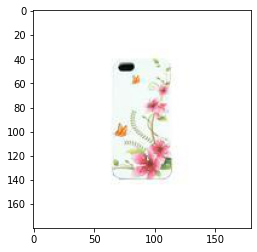

In [47]:
plt.imshow(mpimg.imread(filenames[4]))

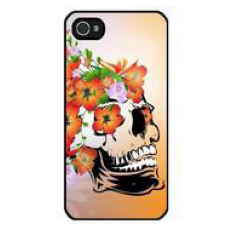

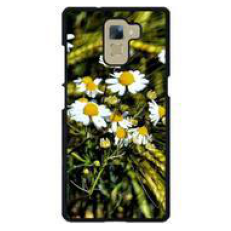

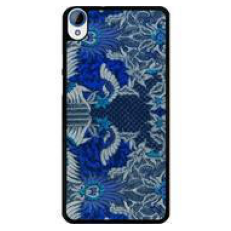

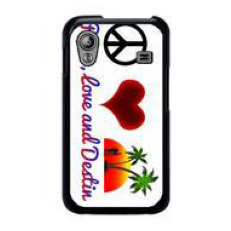

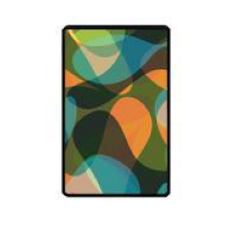

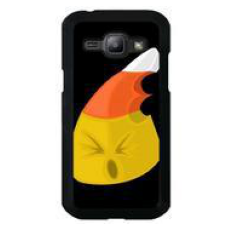

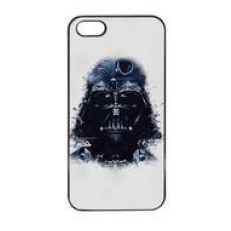

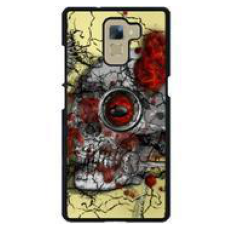

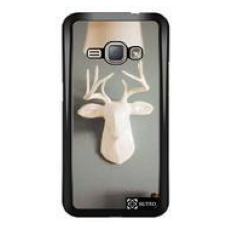

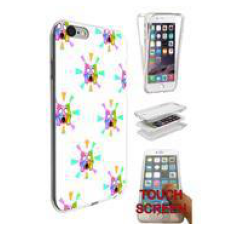

In [48]:
for i in range(indices.shape[1]):
  plt.imshow(mpimg.imread(filenames[indices[0][i]]))
  plt.axis('off')
  plt.show()

ANNOY

In [10]:
#################################################
# Imports and function definitions
#################################################
# For running inference on the TF-Hub module.
import tensorflow as tf
import tensorflow_hub as hub

# For saving 'feature vectors' into a txt file
import numpy as np

# Time for measuring the process time
import time

# Glob for reading file names in a folder
import glob
import os.path
#################################################

#################################################
# This function:
# Loads the JPEG image at the given path
# Decodes the JPEG image to a uint8 W X H X 3 tensor
# Resizes the image to 224 x 224 x 3 tensor
# Returns the pre processed image as 224 x 224 x 3 tensor
#################################################
def load_img(path):

  # Reads the image file and returns data type of string
  img = tf.io.read_file(path)

  # Decodes the image to W x H x 3 shape tensor with type of uint8
  img = tf.io.decode_jpeg(img, channels=3)

  # Resize the image to 224 x 244 x 3 shape tensor
  img = tf.image.resize_with_pad(img, 224, 224)

  # Converts the data type of uint8 to float32 by adding a new axis
  # This makes the img 1 x 224 x 224 x 3 tensor with the data type of float32
  # This is required for the mobilenet model we are using
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

  return img

#################################################
# This function:
# Loads the mobilenet model in TF.HUB
# Makes an inference for all images stored in a local folder
# Saves each of the feature vectors in a file
#################################################
def get_image_feature_vectors():

  i = 0

  start_time = time.time()

  print("---------------------------------")
  print ("Step.1 of 2 - mobilenet_v2_140_224 - Loading Started at %s" %time.ctime())
  print("---------------------------------")

  # Definition of module with using tfhub.dev handle
  module_handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4" 
  
  # Load the module
  module = hub.load(module_handle)

  print("---------------------------------")
  print ("Step.1 of 2 - mobilenet_v2_140_224 - Loading Completed at %s" %time.ctime())
  print("--- %.2f minutes passed ---------" % ((time.time() - start_time)/60))

  print("---------------------------------")
  print ("Step.2 of 2 - Generating Feature Vectors -  Started at %s" %time.ctime())
 

  # Loops through all images in a local folder
  for filename in glob.glob('/content/drive/MyDrive/Colab Notebooks/dataset/output/*.jpg'): #assuming gif
    i = i + 1

    print("-----------------------------------------------------------------------------------------")
    print("Image count                     :%s" %i)
    print("Image in process is             :%s" %filename)

    # Loads and pre-process the image
    img = load_img(filename)

    # Calculate the image feature vector of the img
    features = module(img)   
  
    # Remove single-dimensional entries from the 'features' array
    feature_set = np.squeeze(features)  

    # Saves the image feature vectors into a file for later use

    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path = os.path.join('/content/test/', outfile_name)

    # Saves the 'feature_set' to a text file
    np.savetxt(out_path, feature_set, delimiter=',')

    print("Image feature vector saved to   :%s" %out_path)
  
  print("---------------------------------")
  print ("Step.2 of 2 - Generating Feature Vectors - Completed at %s" %time.ctime())
  print("--- %.2f minutes passed ---------" % ((time.time() - start_time)/60))
  print("--- %s images processed ---------" %i)
    
get_image_feature_vectors()

---------------------------------
Step.1 of 2 - mobilenet_v2_140_224 - Loading Started at Fri Apr 16 20:00:06 2021
---------------------------------
---------------------------------
Step.1 of 2 - mobilenet_v2_140_224 - Loading Completed at Fri Apr 16 20:00:07 2021
--- 0.02 minutes passed ---------
---------------------------------
Step.2 of 2 - Generating Feature Vectors -  Started at Fri Apr 16 20:00:07 2021
-----------------------------------------------------------------------------------------
Image count                     :1
Image in process is             :/content/drive/MyDrive/Colab Notebooks/dataset/output/1.jpg
Image feature vector saved to   :/content/test/1.npz
-----------------------------------------------------------------------------------------
Image count                     :2
Image in process is             :/content/drive/MyDrive/Colab Notebooks/dataset/output/0.jpg
Image feature vector saved to   :/content/test/0.npz
--------------------------------------------

In [12]:
pip install annoy

     |████████████████████████████████| 655kB 20.7MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391627 sha256=85e6e7423c0dd3a4cccbcdb62252ab692fed31d757b8a688c542c1d37059b839
  Stored in directory: /root/.cache/pip/wheels/3a/c5/59/cce7e67b52c8e987389e53f917b6bb2a9d904a03246fadcb1e
Successfully built annoy


In [15]:
import numpy as np
import time

import glob
import os.path
import json
# Annoy and Scipy for similarity calculation
from annoy import AnnoyIndex
from scipy import spatial
def match_id(filename):
    f = open('/content/drive/MyDrive/Colab Notebooks/dataset/image_data.json',)
    data = json.load(f)
    #print(data[0]['imgs'][0]['ImageName'])
    for line in data:
        for img in line['imgs']:
            #print(type(img['ImageName']))
            if str(filename)==str(img['ImageName']):
                #print(img)
                return line['product_id']
                #print(img)
                break
                f.close()
#################################################

#################################################
# This function; 
# Reads all image feature vectores stored in /feature-vectors/*.npz
# Adds them all in Annoy Index
# Builds ANNOY index
# Calculates the nearest neighbors and image similarity metrics
# Stores image similarity scores with productID in a json file
#################################################
def cluster():

  start_time = time.time()
  
  print("---------------------------------")
  print ("Step.1 - ANNOY index generation - Started at %s" %time.ctime())
  print("---------------------------------")

  # Defining data structures as empty dict
  file_index_to_file_name = {}
  file_index_to_file_vector = {}
  file_index_to_product_id = {}

  # Configuring annoy parameters
  dims = 1792
  n_nearest_neighbors = 20
  trees = 10000

  # Reads all file names which stores feature vectors 
  allfiles = glob.glob('/content/test/*.npz')

  t = AnnoyIndex(dims, metric='angular')

  for file_index, i in enumerate(allfiles):
    
    # Reads feature vectors and assigns them into the file_vector 
    file_vector = np.loadtxt(i)

    # Assigns file_name, feature_vectors and corresponding product_id
    file_name=int()
    file_name = os.path.basename(i).split('.')[0]
    print(file_name)
    file_index_to_file_name[file_index] = file_name
    file_index_to_file_vector[file_index] = file_vector
    file_index_to_product_id[file_index] = match_id(file_name)

    # Adds image feature vectors into annoy index   
    t.add_item(file_index, file_vector)

    print("---------------------------------")
    print("Annoy index     : %s" %file_index)
    print("Image file name : %s" %file_name)
    print("Product id      : %s" %file_index_to_product_id[file_index])
    print("--- %.2f minutes passed ---------" % ((time.time() - start_time)/60))


  # Builds annoy index
  t.build(trees)

  print ("Step.1 - ANNOY index generation - Finished")
  print ("Step.2 - Similarity score calculation - Started ") 
  
  named_nearest_neighbors = []
  # Loops through all indexed items
  for i in file_index_to_file_name.keys():

    # Assigns master file_name, image feature vectors and product id values
    master_file_name = file_index_to_file_name[i]
    master_vector = file_index_to_file_vector[i]
    master_product_id = file_index_to_product_id[i]

    # Calculates the nearest neighbors of the master item
    nearest_neighbors = t.get_nns_by_item(i, n_nearest_neighbors)

    # Loops through the nearest neighbors of the master item
    for j in nearest_neighbors:

      print(j)

      # Assigns file_name, image feature vectors and product id values of the similar item
      neighbor_file_name = file_index_to_file_name[j]
      neighbor_file_vector = file_index_to_file_vector[j]
      neighbor_product_id = file_index_to_product_id[j]

      # Calculates the similarity score of the similar item
      similarity = 1 - spatial.distance.cosine(master_vector, neighbor_file_vector)
      rounded_similarity = int((similarity * 10000)) / 10000.0
      
      #print(str(master_product_id)+'---------------++++++++++++++++++++++++++++++++++++++++++')
      # Appends master product id with the similarity score 
      # and the product id of the similar items
      named_nearest_neighbors.append({
        'similarity': rounded_similarity,
        'master_pi': master_product_id,
        'similar_pi': neighbor_product_id})

    print("---------------------------------") 
    print("Similarity index       : %s" %i)
    print("Master Image file name : %s" %file_index_to_file_name[i]) 
    print("Nearest Neighbors.     : %s" %nearest_neighbors) 
    print("--- %.2f minutes passed ---------" % ((time.time() - start_time)/60))

  
  print ("Step.2 - Similarity score calculation - Finished ") 

  # Writes the 'named_nearest_neighbors' to a json file
  with open('/content/nearest_neighbors.json', 'w') as out:
    json.dump(named_nearest_neighbors, out, indent=2)

  print("Step.3 - Data stored in 'nearest_neighbors.json' file ") 
  print("--- Prosess completed in %.2f minutes ---------" % ((time.time() - start_time)/60))

cluster()

---------------------------------
Step.1 - ANNOY index generation - Started at Fri Apr 16 20:19:39 2021
---------------------------------
97
---------------------------------
Annoy index     : 0
Image file name : 97
Product id      : 89
--- 0.00 minutes passed ---------
21
---------------------------------
Annoy index     : 1
Image file name : 21
Product id      : 19
--- 0.00 minutes passed ---------
109
---------------------------------
Annoy index     : 2
Image file name : 109
Product id      : 101
--- 0.00 minutes passed ---------
60
---------------------------------
Annoy index     : 3
Image file name : 60
Product id      : 54
--- 0.00 minutes passed ---------
24
---------------------------------
Annoy index     : 4
Image file name : 24
Product id      : 25
--- 0.00 minutes passed ---------
10
---------------------------------
Annoy index     : 5
Image file name : 10
Product id      : 11
--- 0.00 minutes passed ---------
105
---------------------------------
Annoy index     : 6
Ima